## MNIST Autoencoder exercise - reconstruction of noisy digits ##
**Goal: Introduction Auto encoder/decoder **

**Exercise:**
    
Run the notebook, observe the reconstruction of noisy images 

Try changing the amount of noise

Try adding a skip connection and see how it affects the reconstruction
  (look at the fwd method of the Decoder subnetwork)



In [34]:
#| export
# ----------- IMPORT STATEMENTS ---------------
import argparse
import torch
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import os
import sys
import numpy as np
import time


#---------------------------------------------
print('import done')

import done


In [35]:
#| export
# -----------------------------------
#Parameters for training
# -----------------------------------
num_worker2use = 0    #for parallel reading/prefetching of (bigger) data
batch_size     = 128 #1024  
max_numtrain   = 1024 #4096       #for this exercise, train on limited num of input, to save time
max_numtest    = batch_size # and test on limited num of input
epochs         = 100
lrate          = 0.01
numfilt        = 16
num_xtra_noise_steps=15    #<<<<<<<<<<------------ (15 to 25 is large-ish, 0 to 5 is smallish)

torch.manual_seed(776)


In [36]:
#| export
#We'll load data into arrays directly
X_train=np.load("./X_train1k.npy")
Y_train=np.load("./Y_train1k.npy")
X_test =np.load("./X_test.npy")[0:max_numtrain,] #take 1k out of the 10k images
Y_test=np.load("./Y_test.npy")[0:max_numtest,]

#Scale 0 to 1  - or should we not scale
X_train = X_train/255.0
X_test  = X_test/255.0

X_train = X_train[:,np.newaxis,:, :]
X_test  = X_test[:,np.newaxis,:, :]


print(X_train.shape) 
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(1000, 1, 28, 28)
(1000,)
(1024, 1, 28, 28)
(128,)


In [37]:
print(np.max(X_train))

1.0


In [38]:
#| export
#Add some noise to make it harder
def addnoise(X):
    #X=X + np.round(np.random.uniform(-1,1,size=X.shape),1) using round adds full pixel or nothing
    X=X + np.random.uniform(-0.2,0.2,size=X.shape)
    X[np.where(X>1)]=1
    X[np.where(X<0)]=0
    return X

X_train_wnoise = addnoise(X_train)
X_test_wnoise  = addnoise(X_test)

for i in range(num_xtra_noise_steps):
  print('adding more noise, step',i)
  X_train_wnoise = addnoise(X_train_wnoise)
  X_test_wnoise  = addnoise(X_test_wnoise)
print('noise added')
print(np.max(X_train_wnoise))
print(np.max(X_test_wnoise))


adding more noise, step 0
adding more noise, step 1
adding more noise, step 2
adding more noise, step 3
adding more noise, step 4
adding more noise, step 5
adding more noise, step 6
adding more noise, step 7
adding more noise, step 8
adding more noise, step 9
adding more noise, step 10
adding more noise, step 11
adding more noise, step 12
adding more noise, step 13
adding more noise, step 14
noise added
1.0
1.0


In [39]:
#| export
#Set up arrays as 'tensor datasets' 
from torch.utils.data import TensorDataset, DataLoader

X_train_wnoise_tensor = torch.from_numpy(X_train_wnoise).float() # Use .float() for float data
X_train_tensor        = torch.from_numpy(X_train).float() 
Y_train_tensor        = torch.from_numpy(Y_train).long()  
X_test_wnoise_tensor  = torch.from_numpy(X_test_wnoise).float() 
X_test_tensor         = torch.from_numpy(X_test).float() 
Y_test_tensor         = torch.from_numpy(Y_test).long()  # Use .long() for integer labels

# Combine input and target tensors into a TensorDataset object
my_train_dataset = TensorDataset(X_train_wnoise_tensor, X_train_tensor)
my_test_dataset  = TensorDataset(X_test_wnoise_tensor, X_test_tensor)

print('train,test tensor datasets set up')

train,test tensor datasets set up


In [40]:
#| export
# -------------------------------------------
#prepare images for network as they are loaded
# -------------------------------------------
train_loader =torch.utils.data.DataLoader(my_train_dataset, 
            batch_size =batch_size,     sampler   =None,
            num_workers=num_worker2use, pin_memory=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(my_test_dataset, 
            batch_size =batch_size,     sampler   =None,
            num_workers=num_worker2use, pin_memory=False, drop_last=True)


In [41]:
#| export
#Sample of how to access data
with torch.no_grad():
  for batch_idx, (data, target) in enumerate(train_loader):
      #output=data
      break
print(data.shape)
print(target.shape)
#print(torch.max(data))

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


In [42]:
#| export
# -------------------------------------------------------------
#   Define network class object and its 
#             initialization and forward function
#             (other functions are inherited from torch.nn)
# -------------------------------------------------------------
class MyEncoder(torch.nn.Module):
    def __init__(self):
        super(MyEncoder, self).__init__()
        #convolution layer then max pool to downsize, 
        self.conv1      = torch.nn.Conv2d(1, numfilt, 3, 1,padding='same')
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        #repeat the block but double the filters
        self.conv2      = torch.nn.Conv2d(numfilt, numfilt*2, 3, 1,padding='same')
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        #print('MYINFO enc fwd, x shp:',x.shape)
        x1 = self.conv1(x)   
        x1 = F.relu(x1)
        x1 = self.max_pool_1(x1)
        #print('MYINFO enc fwd, after max1, x shape:',x1.shape)
        x2 = self.conv2(x1)
        x2 = F.relu(x2)
        x2 = self.max_pool_2(x2)
        return x1,x2    #or x1,x2 to use skip connections
# ---------------------------------------------------------------------
# decoder
# ---------------------------------------------------------------------
class MyDecoder(torch.nn.Module):
    def __init__(self):
        super(MyDecoder, self).__init__()
        #convolution layer then max pool to downsize, 
        self.conv1      = torch.nn.Conv2d(numfilt*2, numfilt, 3, 1,padding='same')

        #if no skip connection use in channels = numfilt for Conv2
        self.conv2      = torch.nn.Conv2d(numfilt, numfilt, 3, 1,padding='same')

        # <<<<<<<<<-------------- uncomment this, comment out the above
        #for skip connection going into conv2 use mumfilt*2
        #self.conv2      = torch.nn.Conv2d(numfilt*2, numfilt, 3, 1,padding='same')

        #last conv is 1 filter, and will use sigmoidal activation bc this is the output layer
        self.conv3      = torch.nn.Conv2d(numfilt, 1, 3, 1,padding='same')
    def forward(self, encx1,x):  #or use x1,x2 inputs
        x1 = self.conv1(x)   
        x1 = F.relu(x1)
        x1  =torch.nn.functional.interpolate(x1,size=(14,14),mode='nearest')
        #print('MYINFO dec fwd, after inter1, x shape:',x1.shape, 'encx1shp',encx1.shape)
        skip_concat_1 = torch.cat((x1,encx1), dim=1)
        #print('MYINFO, dec fwd, after concat1',skip_concat_1.shape)

        #<<<<<<---------- choose if x2 should use x1 alone, or x1 concat with skip conntn
        x2 = self.conv2(x1)
        #x2 = self.conv2(skip_concat_1)

        x2 = F.relu(x2)
        x2  =torch.nn.functional.interpolate(x2,size=(28,28),mode='nearest')
        #print('MYINFO dec fwd, after inter2, x shape:',x2.shape)
        x3 = self.conv3(x2)
        x3 = F.sigmoid(x3)
        return x3 
        
class MyAENet(torch.nn.Module):
    def __init__(self):
        super(MyAENet, self).__init__()
        self.encoder = MyEncoder()
        self.decoder = MyDecoder()
        #self.bottleneck = torch.nn.Conv2d(numfilt, numfilt, 3, 1)

    def forward(self, x):
        encx1,x2 = self.encoder(x)
        output = self.decoder(encx1,x2)  #output is between 0 and 1
        #print('MYINFO  fwd, after max, x shape:',x.shape)
        return output
print('Net class defined ')

Net class defined 


In [43]:
#| export
# --------------------------------------------------------
#   Define training function
# --------------------------------------------------------
def train(model, device, train_loader, optimizer, epoch):
    ''' This is called for each epoch.  
        Arguments:  the model, the device to run on, data loader, optimizer, and current epoch
    ''' 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      if batch_idx*batch_size>= max_numtrain:
           break
      else:
        if batch_idx==0:
           print('INFO train, ep:',epoch,' batidx:',batch_idx, ' batch size:',target.shape[0])
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()                 #reset optimizer state
        output = model(data)                  #get predictions

        loss = torch.nn.functional.binary_cross_entropy(output,target)
        loss.backward()                       #backprop loss
        optimizer.step()                      #update weights

# -------------------------------------------------------------
#   Define test function
# -------------------------------------------------------------
def test(model, device, test_loader):
    ''' This is called for after training each epoch 
        Arguments:  the model, the device to run on, test data loader
    ''' 
    model.eval()

    #accumulate loss, accuracy info
    total_loss    = 0
    total_correct = 0
    total         = 0
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
        if batch_idx*batch_size>= max_numtest:
           break
        else:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            total_loss  += torch.nn.functional.binary_cross_entropy(output,target)
            total +=data.shape[0]
           
    test_loss = total_loss/total 
    print('INFO test loss:',f'{test_loss:.4}','tot:',total)
    return test_loss

print('Train,test, support functions defined ')

Train,test, support functions defined 


In [44]:
#| export
# -------------------------------------------------
#  Get device  
#  (note, this is set up for 1 GPU device
#    if this were to run on a full GPU node with >1 gpu device, you would
#     want to get rank, world size info and set device id 
#     as in:   torch.cuda.set_device(local_rank) 
#     and then also run distributed initialization )
# -------------------------------------------------
use_cuda = torch.cuda.is_available() 
if use_cuda:
        num_gpu = torch.cuda.device_count()
        print('INFO,  cuda, num gpu:',num_gpu)
        device     = torch.cuda.current_device()
        print('environ visdevs:',os.environ["CUDA_VISIBLE_DEVICES"])
else:
        num_gpu = 0
        print('INFO, cuda not available')
        device  = torch.device("cpu")   
print('INFO, device is:', device)

INFO, cuda not available
INFO, device is: cpu


In [45]:
#| export
# -------------------------------------------
#  Set up model and do training loop
# -------------------------------------------
mymodel = MyAENet().to(device)

#summary(mymodel,input_size=(1, 1, 28, 28))


In [46]:
#| export
#Do training loop
# =---------------------------------------
optimizer = torch.optim.Adam(mymodel.parameters(), lr=lrate)

train_results = []
test_results  = []
for epoch in range(epochs):
        print('INFO about to train epoch:',epoch)
        start_time=time.time()
        train(mymodel, device, train_loader, optimizer, epoch)
        print('INFO training time:',str.format('{0:.5f}', time.time()-start_time))
        print('INFO about to test epoch:',epoch)
        test(mymodel,device,train_loader)
        test(mymodel,device,test_loader)

print('INFO  done');


INFO about to train epoch: 0
INFO train, ep: 0  batidx: 0  batch size: 128
INFO training time: 0.15889
INFO about to test epoch: 0
INFO test loss: 0.003821 tot: 128
INFO test loss: 0.003736 tot: 128
INFO about to train epoch: 1
INFO train, ep: 1  batidx: 0  batch size: 128
INFO training time: 0.14330
INFO about to test epoch: 1
INFO test loss: 0.003146 tot: 128
INFO test loss: 0.00305 tot: 128
INFO about to train epoch: 2
INFO train, ep: 2  batidx: 0  batch size: 128
INFO training time: 0.13961
INFO about to test epoch: 2
INFO test loss: 0.002576 tot: 128
INFO test loss: 0.002489 tot: 128
INFO about to train epoch: 3
INFO train, ep: 3  batidx: 0  batch size: 128
INFO training time: 0.13687
INFO about to test epoch: 3
INFO test loss: 0.002135 tot: 128
INFO test loss: 0.002056 tot: 128
INFO about to train epoch: 4
INFO train, ep: 4  batidx: 0  batch size: 128
INFO training time: 0.13711
INFO about to test epoch: 4
INFO test loss: 0.002007 tot: 128
INFO test loss: 0.001953 tot: 128
INFO a

In [47]:
#=====================

In [48]:
#To view sample images
import matplotlib.pyplot as plt      #These provide matlab type of plotting functions
import matplotlib.image as mpimg

def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


 disply noisy images --------------------
 disply target images --------------------
 disply output reconstruction ---------------


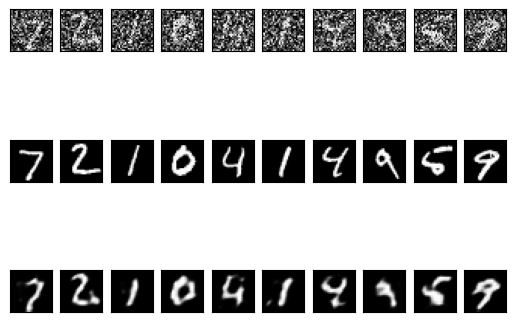

In [49]:
#get sample outputs and show original,noisy,reconstructed images
with torch.no_grad():
  for batch_idx, (data, target) in enumerate(test_loader):
      output=mymodel(data.to(device)).detach().cpu()  
      break

num2do=10
print(' disply noisy images --------------------')
display_one_row(data[0:num2do,], 0, shape=(28,28,))
print(' disply target images --------------------')
display_one_row(target[0:num2do,], 10, shape=(28,28,))
print(' disply output reconstruction ---------------')
display_one_row(output[0:num2do,], 20, shape=(28,28,))

 disply noisy images --------------------
 disply target images --------------------
 disply output reconstruction ---------------


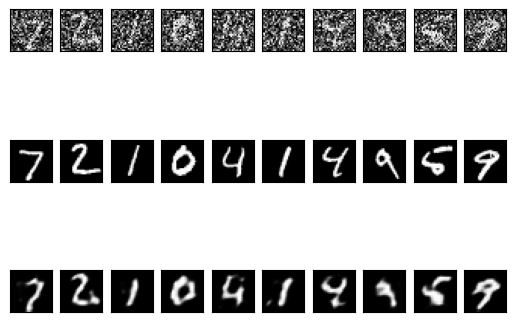

In [50]:
# Set it to 0 and so that if you rerun all cells it 
# won't clear out the images

#get sample outputs and show original,noisy,reconstructed images
if 1:
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output=mymodel(data.to(device)).detach().cpu()  
        break

  num2do=10
  print(' disply noisy images --------------------')
  display_one_row(data[0:num2do,], 0, shape=(28,28,))
  print(' disply target images --------------------')
  display_one_row(target[0:num2do,], 10, shape=(28,28,))
  print(' disply output reconstruction ---------------')
  display_one_row(output[0:num2do,], 20, shape=(28,28,))
